# Notebook 3.0 - Trích xuất đặc trưng Mel Spectrogram

## Cell 1: Import thư viện
Cell này import các thư viện cần thiết:
- `os`, `numpy`: xử lý file và mảng
- `librosa`: xử lý âm thanh
- `tqdm`: hiển thị tiến trình
- `pandas`: xử lý dữ liệu dạng bảng
- `tensorflow`: resize ảnh
- `matplotlib`, `seaborn`: hiển thị đồ thị

In [17]:
import os
import numpy as np
import librosa
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Cell 2: Tạo thư mục lưu trữ
Tạo thư mục để lưu các đặc trưng mel spectrogram đã trích xuất.


In [18]:
os.makedirs('../data/features/mel', exist_ok=True)

## Cell 3: Định nghĩa hàm trích xuất Mel Spectrogram
Hàm `extract_mel_spectrogram` thực hiện:
- Tải file âm thanh
- Trích xuất mel spectrogram với các tham số:
  - 128 mel bins
  - FFT size 2048
  - Hop length 128
- Chuyển đổi sang thang dB
- Chuẩn hóa về khoảng [0,1]
- Resize về kích thước cố định (128, 32)

In [19]:
def extract_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=128):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmin=20,
        fmax=sr/2,
        power=2.0
    )
    
    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize to range [0,1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    
    # Resize to fixed dimensions (128, 32)
    mel_spec_norm = tf.image.resize(mel_spec_norm[..., np.newaxis], (128, 32))
    mel_spec_norm = mel_spec_norm.numpy()
    mel_spec_norm = mel_spec_norm[..., 0]
    
    return mel_spec_norm


## Cell 4: Thu thập danh sách file
Thu thập tất cả các file WAV từ thư mục processed để xử lý.


In [20]:
processed_dir = '../data/processed'
audio_files = []
for root, dirs, files in os.walk(processed_dir):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))


## Cell 5: Trích xuất và lưu đặc trưng
Cell này thực hiện:
- Duyệt qua từng file âm thanh
- Trích xuất mel spectrogram
- Lưu đặc trưng dưới dạng file .npy
- Tạo metadata chứa thông tin về:
  - Đường dẫn file âm thanh
  - Đường dẫn file đặc trưng
  - Kích thước mel spectrogram
  - Độ dài âm thanh
  - Tần số lấy mẫu

In [21]:
# Initialize metadata list
metadata = []

# Process each audio file
for audio_path in tqdm(audio_files):
    # Get relative path from processed directory
    rel_path = os.path.relpath(audio_path, processed_dir)
    # Create corresponding directory in features
    feature_dir = os.path.join('../data/features/mel', os.path.dirname(rel_path))
    os.makedirs(feature_dir, exist_ok=True)
    
    # Extract mel spectrogram
    mel_features = extract_mel_spectrogram(audio_path)
    
    # Save features with same name but .npy extension
    feature_path = os.path.join(feature_dir, os.path.splitext(os.path.basename(audio_path))[0] + '.npy')
    np.save(feature_path, mel_features)
    
    # Add to metadata
    metadata.append({
        'audio_path': rel_path,
        'feature_path': os.path.relpath(feature_path, '../data/features/mel'),
        'mel_shape': mel_features.shape,
        'duration': librosa.get_duration(path=audio_path),
        'sr': librosa.get_samplerate(audio_path)
    })

# Convert metadata to DataFrame and save
metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv('../data/features/mel/metadata.csv', index=False)


100%|██████████| 1853/1853 [00:18<00:00, 99.01it/s] 


## Cell 6: Hiển thị thống kê cơ bản
Hiển thị:
- Tổng số file đã xử lý
- Phân bố kích thước mel spectrogram
- Mẫu dữ liệu đầu tiên


In [22]:
print("Metadata Summary:")
print(f"Total files processed: {len(metadata_df)}")
print("\nFeature shapes:")
print(metadata_df['mel_shape'].value_counts())

# Display first few rows of metadata
print("\nFirst few entries:")
print(metadata_df.head())

Metadata Summary:
Total files processed: 1853

Feature shapes:
mel_shape
(128, 32)    1853
Name: count, dtype: int64

First few entries:
                          audio_path                       feature_path  \
0  bat_den/bat_den_speaker01_001.wav  bat_den/bat_den_speaker01_001.npy   
1  bat_den/bat_den_speaker01_002.wav  bat_den/bat_den_speaker01_002.npy   
2  bat_den/bat_den_speaker01_003.wav  bat_den/bat_den_speaker01_003.npy   
3  bat_den/bat_den_speaker01_004.wav  bat_den/bat_den_speaker01_004.npy   
4  bat_den/bat_den_speaker01_005.wav  bat_den/bat_den_speaker01_005.npy   

   mel_shape  duration     sr  
0  (128, 32)       1.0  16000  
1  (128, 32)       1.0  16000  
2  (128, 32)       1.0  16000  
3  (128, 32)       1.0  16000  
4  (128, 32)       1.0  16000  


## Cell 7: Phân tích và hiển thị đặc trưng
Cell này thực hiện nhiều phân tích trực quan:
1. Hiển thị mel spectrogram của 4 file đầu tiên
2. Phân tích thống kê:
   - Đồ thị mean và std theo mel bin
   - Đồ thị max và min theo mel bin
3. Phân tích tương quan:
   - Ma trận tương quan giữa các mel bin
   - Box plot phân bố giá trị
   - Histogram phân bố giá trị
4. In thống kê chi tiết về quá trình xử lý



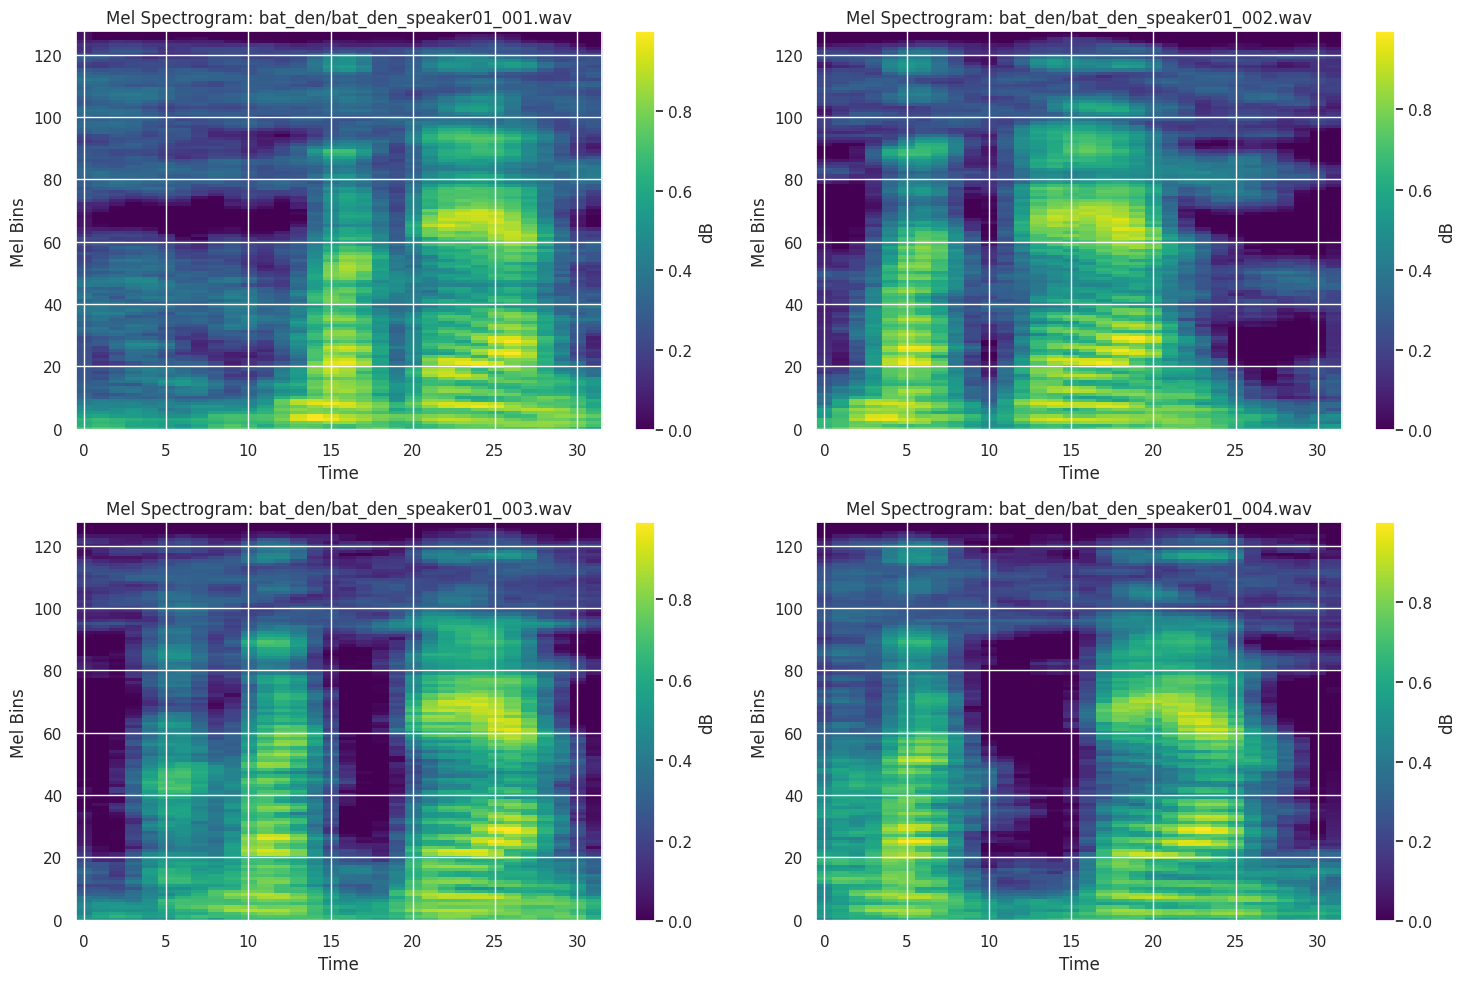

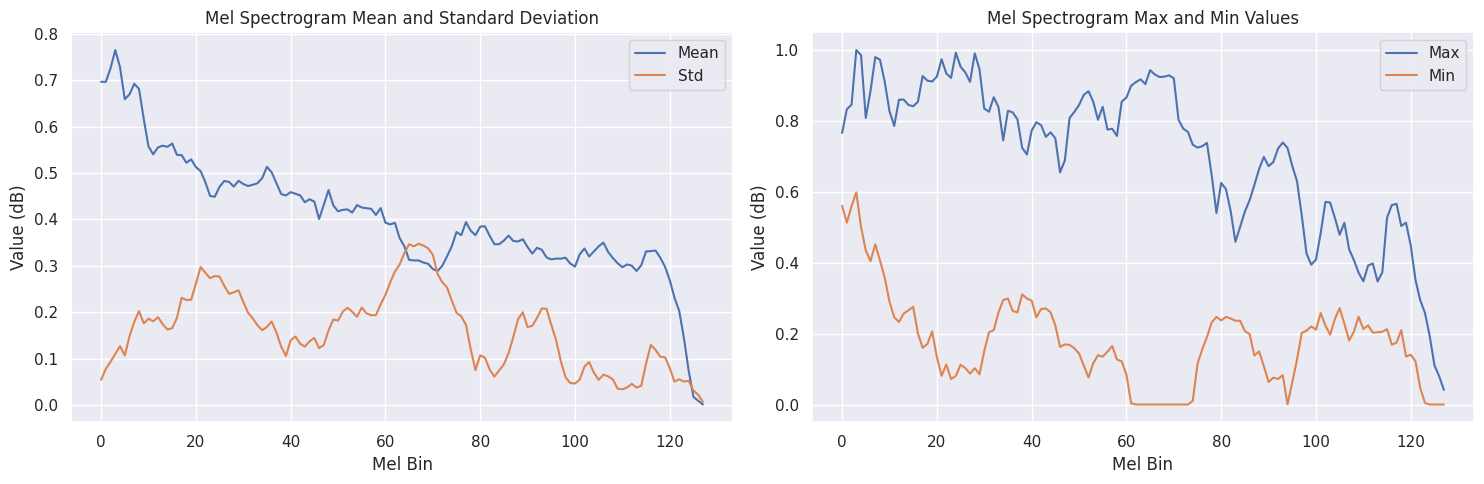

In [23]:
# Set style using seaborn directly to avoid deprecation warning
import seaborn as sns
sns.set_theme()

# 1. Mel Spectrogram Heatmap
plt.figure(figsize=(15, 10))
n_examples = min(4, len(metadata_df))

for i in range(n_examples):
    plt.subplot(2, 2, i+1)
    feature_path = os.path.join('../data/features/mel', metadata_df.iloc[i]['feature_path'])
    mel_features = np.load(feature_path)
    
    plt.imshow(mel_features, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Mel Spectrogram: {metadata_df.iloc[i]["audio_path"]}')
    plt.xlabel('Time')
    plt.ylabel('Mel Bins')
    plt.colorbar(label='dB')

plt.tight_layout()
plt.show()

# 2. Mel Spectrogram Statistics
plt.figure(figsize=(15, 5))

feature_path = os.path.join('../data/features/mel', metadata_df.iloc[0]['feature_path'])
mel_features = np.load(feature_path)

plt.subplot(1, 2, 1)
plt.plot(mel_features.mean(axis=1), label='Mean')
plt.plot(mel_features.std(axis=1), label='Std')
plt.title('Mel Spectrogram Mean and Standard Deviation')
plt.xlabel('Mel Bin')
plt.ylabel('Value (dB)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mel_features.max(axis=1), label='Max')
plt.plot(mel_features.min(axis=1), label='Min')
plt.title('Mel Spectrogram Max and Min Values')
plt.xlabel('Mel Bin')
plt.ylabel('Value (dB)')
plt.legend()

plt.tight_layout()
plt.show()

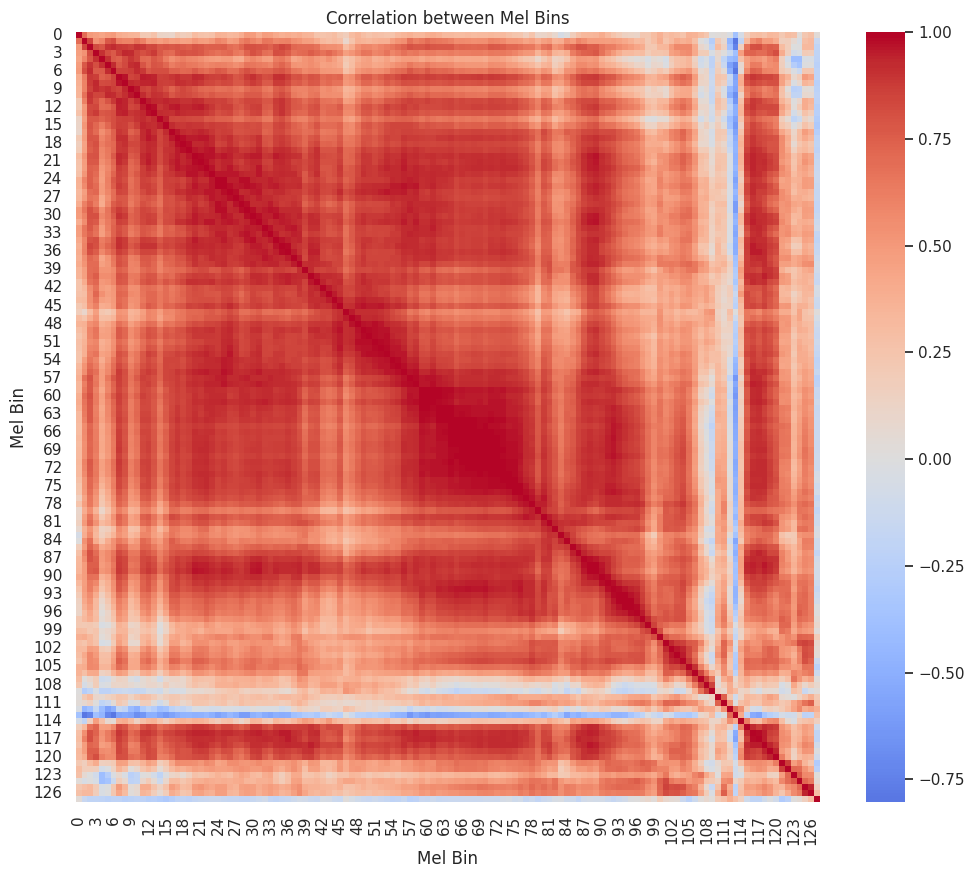

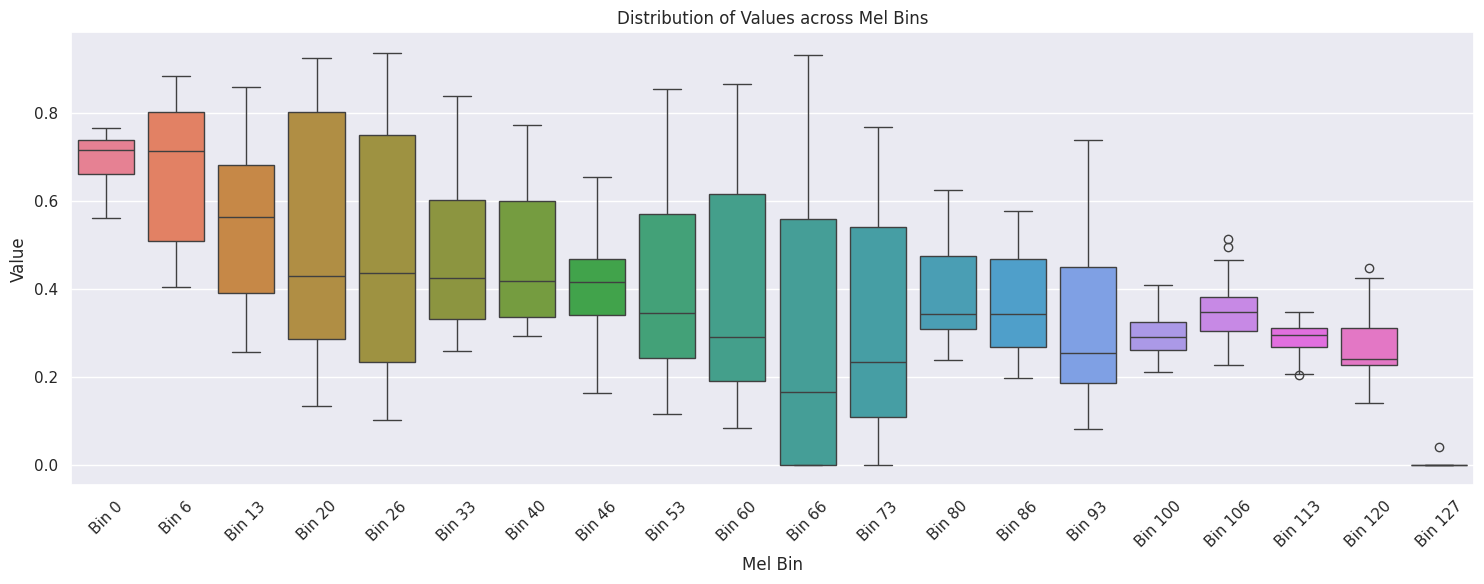

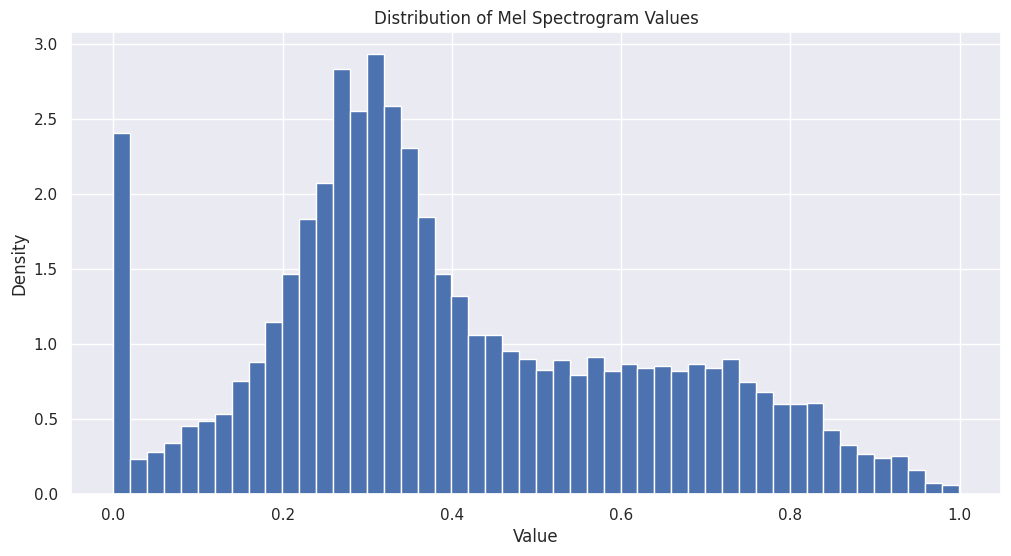


Detailed Processing Statistics:
Total number of files processed: 1853
Number of unique sample rates: 1
Most common sample rate: 16000 Hz

Mel Spectrogram Statistics:
Shape of mel spectrograms: (128, 32)
Mean value: 0.4029
Standard deviation: 0.2246
Minimum value: 0.0000
Maximum value: 0.9987


In [24]:
# Mel Spectrogram Correlation Analysis
plt.figure(figsize=(12, 10))
feature_path = os.path.join('../data/features/mel', metadata_df.iloc[0]['feature_path'])
mel_features = np.load(feature_path)
correlation_matrix = np.corrcoef(mel_features)
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation between Mel Bins')
plt.xlabel('Mel Bin')
plt.ylabel('Mel Bin')
plt.show()

# Box Plot of Mel Spectrogram Values
plt.figure(figsize=(15, 6))
# Select a subset of mel bins for better visualization
selected_bins = np.linspace(0, mel_features.shape[0]-1, 20, dtype=int)
box_data = pd.DataFrame(mel_features[selected_bins].T, columns=[f'Bin {i}' for i in selected_bins])
sns.boxplot(data=box_data)
plt.title('Distribution of Values across Mel Bins')
plt.xlabel('Mel Bin')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Value Distribution in Mel Spectrogram
plt.figure(figsize=(12, 6))
plt.hist(mel_features.flatten(), bins=50, density=True)
plt.title('Distribution of Mel Spectrogram Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Detailed Processing Statistics
print("\nDetailed Processing Statistics:")
print(f"Total number of files processed: {len(metadata_df)}")
print(f"Number of unique sample rates: {metadata_df['sr'].nunique()}")
print(f"Most common sample rate: {metadata_df['sr'].mode()[0]} Hz")
print("\nMel Spectrogram Statistics:")
print(f"Shape of mel spectrograms: {mel_features.shape}")
print(f"Mean value: {mel_features.mean():.4f}")
print(f"Standard deviation: {mel_features.std():.4f}")
print(f"Minimum value: {mel_features.min():.4f}")
print(f"Maximum value: {mel_features.max():.4f}")

Mục đích của notebook này là:
1. Trích xuất đặc trưng mel spectrogram từ âm thanh
2. Chuẩn hóa và lưu trữ đặc trưng
3. Phân tích và hiển thị đặc trưng
4. Chuẩn bị dữ liệu cho quá trình huấn luyện mô hình